# LHb data, cell number 89 (6 in the new numbering)

In [1]:
import pyabf  # Load pyABF
import matplotlib.pyplot as plt
%matplotlib widget
from math import *
from matplotlib.backend_bases import MouseButton
import numpy as np
import pandas as pd
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import skew, kurtosis
import seaborn as sns

In [2]:
file_path_89 = "../lhb_bursting/cell89basal.abf"  # we select the abf record file
abf = pyabf.ABF(file_path_89)                 # we load it
print(abf)                                    # record characteristics 

ABF (v2.6) with 1 channel (pA), sampled at 10.0 kHz, containing 30 sweeps, having no tags, with a total length of 11.11 minutes, recorded without a protocol file.


In [3]:
methods = [method for method in dir(abf) if callable(getattr(abf, method)) and not method.startswith("__")]
print("\n".join(methods))

_dtype
_getAdcNameAndUnits
_getDacNameAndUnits
_ide_helper
_loadAndScaleData
_makeAdditionalVariables
_readHeadersV1
_readHeadersV2
getAllXs
getAllYs
headerLaunch
launchInClampFit
saveABF1
setSweep
sweepD


In [4]:
# Print voltage trace (recorded signal)
print(f"{'Voltage Trace (mV):':>25} {abf.sweepY}")

# Print command input (if available)
print(f"{'Command Input (mV):':>25} {abf.sweepC}")

      Voltage Trace (mV): [-61.2   -60.856 -61.2   ... -56.228 -56.196 -56.353]
      Command Input (mV): [0. 0. 0. ... 0. 0. 0.]


In [5]:
# Choose a specific sweep (e.g., first sweep -> index 0)  
sweep_index = 0  
abf.setSweep(sweep_index)  

# Print voltage trace (recorded signal)
print(f"{'Voltage Trace (mV):':>25} {abf.sweepY}")

# Print command input (if available)
print(f"{'Command Input (mV):':>25} {abf.sweepC}")

# Check all available ADC channels (recorded signals)
print(f"{'Recorded Channels:':>25} {abf.adcNames}")

# Check DAC channels (command input signals)
print(f"{'Command Channels:':>25} {abf.dacNames}")

      Voltage Trace (mV): [-61.2   -60.856 -61.2   ... -56.228 -56.196 -56.353]
      Command Input (mV): [0. 0. 0. ... 0. 0. 0.]
       Recorded Channels: ['Waveform']
        Command Channels: ['AO #0']



Voltage Trace Statistics:
           Mean (mV): -55.656
         Median (mV): -56.853
            Min (mV): -66.204
            Max (mV): 49.191
        Std Dev (mV): 9.172
          Range (mV): 115.395


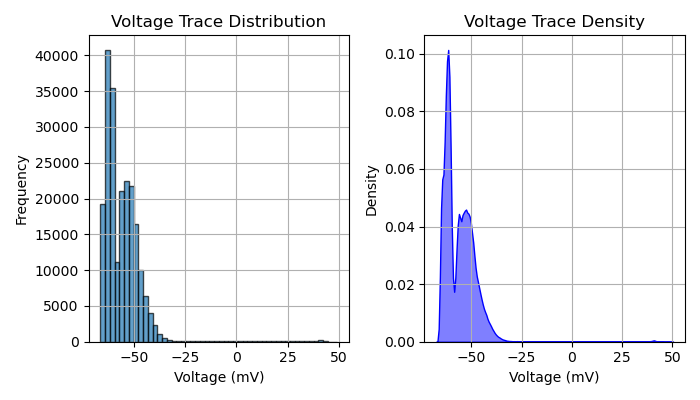

In [6]:
data = abf.sweepY  # The voltage trace

stats = {
    "Mean (mV)"   : np.mean(data),
    "Median (mV)" : np.median(data),
    "Min (mV)"    : np.min(data),
    "Max (mV)"    : np.max(data),
    "Std Dev (mV)": np.std(data),
    "Range (mV)"  : np.ptp(data),  # Max - Min
}

print("\nVoltage Trace Statistics:")
for key, value in stats.items():
    print(f"{key:>20}: {value:.3f}")


# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

# Plot histogram on the first subplot
axes[0].hist(data, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel("Voltage (mV)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Voltage Trace Distribution")
axes[0].grid(True)

# Plot KDE on the second subplot
sns.kdeplot(data, bw_adjust=0.5, fill=True, color="b", alpha=0.5, ax=axes[1])
axes[1].set_xlabel("Voltage (mV)")
axes[1].set_ylabel("Density")
axes[1].set_title("Voltage Trace Density")
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

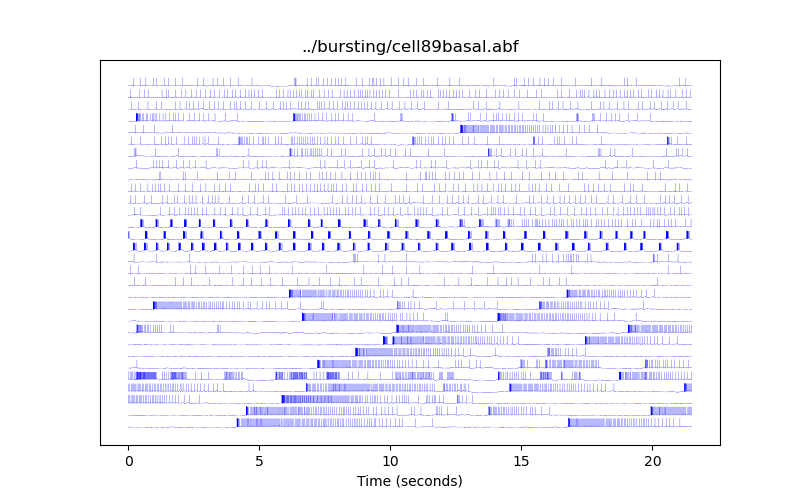

In [7]:
def plot_abf():
    plt.figure(figsize=(8, 5))

    # Plot every sweep with vertical offset
    for sweepNumber in abf.sweepList:
        abf.setSweep(sweepNumber)
        offset = 140 * sweepNumber
        plt.plot(abf.sweepX, abf.sweepY + offset, color='b', lw=0.1)  # Recorded voltage
        #plt.plot(abf.sweepX, abf.sweepC + offset, color='r', lw=0.5)  # Command waveform in red

    # Decorate the plot
    plt.gca().get_yaxis().set_visible(False)  # Hide Y axis
    plt.title(file_path_89)
    plt.xlabel(abf.sweepLabelX)
    plt.show()

plot_abf()

In [8]:
# Sampling rate
fs = int(abf.dataPointsPerMs * 1000)
 
# Lowpass Bessel filter
b_lowpass, a_lowpass = signal.bessel(4,     # Order of the filter
                                     2000,  # Cutoff frequency
                                     'low', # Type of filter
                                     analog=False,  # Analog or digital filter
                                     norm='phase',  # Critical frequency normalization
                                     fs=fs)  # fs: sampling frequency
 
signal_filtered = signal.filtfilt(b_lowpass, a_lowpass, abf.sweepY)

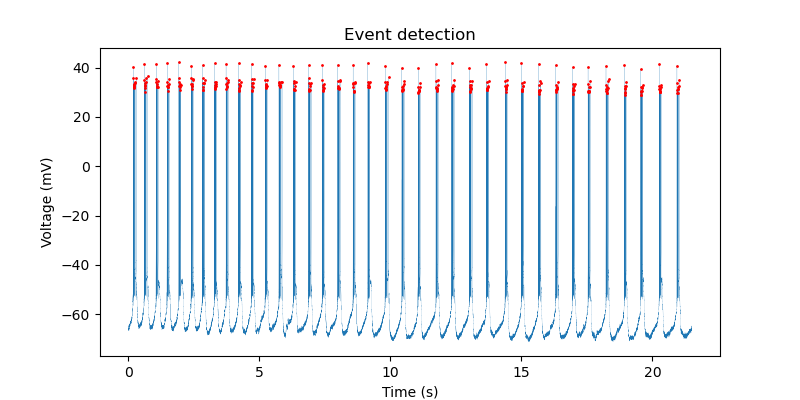

,spike,spike_index,spike_time,inst_freq,isi_s,width,rise_half_ms,decay_half_ms,spike_peak,spike_amplitude
0,1,1933,0.1933,inf,0.0000,0.567354,0.203017,0.364337,40.091000,105.951000
1,2,1985,0.1985,192.307692,0.0052,0.576342,0.178124,0.398218,35.776001,92.254002
2,3,2041,0.2041,178.571429,0.0056,0.582079,0.170146,0.411933,33.273998,86.373997
3,4,2105,0.2105,156.250000,0.0064,0.616574,0.239908,0.376665,32.084999,85.059998
4,5,2177,0.2177,138.888889,0.0072,0.636234,0.183315,0.452919,31.554001,83.778999
...,...,...,...,...,...,...,...,...,...,...
352,353,209610,20.9610,138.888889,0.0072,0.646102,0.235399,0.410703,31.334999,83.966000
353,354,209692,20.9692,121.951220,0.0082,0.659416,0.185940,0.473476,29.677000,81.651999
354,355,209800,20.9800,92.592593,0.0108,0.648763,0.201138,0.447625,32.304001,85.528999
355,356,209944,20.9944,69.444444,0.0144,0.650395,0.187382,0.463013,32.522999,85.935997


In [10]:
# Assign the variables here to simplify the code
time = abf.sweepX
peaks_signal = abf.sweepY  # Or signal_filtered
abf.setSweep(15)

# Set parameters for the Find peaks function (set to None if not needed)
thresh_min = -40                    # Min threshold to detect spikes
thresh_prominence = 15              # Min spike amplitude  
thresh_min_width = 0.3 * (fs/1000)  # Min required width in ms
distance_min = 1 * (fs/1000)        # Min horizontal distance between peaks
pretrigger_window = (1.5 * fs)/1000
posttrigger_window = (2 * fs)/1000
 
# Find peaks function
peaks, peaks_dict = find_peaks(peaks_signal, 
           height=thresh_min, 
           threshold=thresh_min,  
           distance=distance_min,  
           prominence=thresh_prominence,  
           width=thresh_min_width, 
           wlen=None,       # Window length to calculate prominence
           rel_height=0.5,  # Relative height at which the peak width is measured
           plateau_size=None)
  
# Create table with results
spikes_table = pd.DataFrame(columns = ['spike', 'spike_index', 'spike_time',
                                       'inst_freq', 'isi_s',
                                       'width', 'rise_half_ms', 'decay_half_ms',
                                       'spike_peak', 'spike_amplitude'])
 
spikes_table.spike = np.arange(1, len(peaks) + 1)
spikes_table.spike_index = peaks
spikes_table.spike_time = peaks / fs  # Divided by fs to get s
spikes_table.isi_s = np.diff(peaks, axis=0, prepend=peaks[0]) / fs
spikes_table.inst_freq = 1 / spikes_table.isi_s
spikes_table.width = peaks_dict['widths']/(fs/1000) # Width (ms) at half-height
spikes_table.rise_half_ms = (peaks - peaks_dict['left_ips'])/(fs/1000) 
spikes_table.decay_half_ms = (peaks_dict['right_ips'] - peaks)/(fs/1000)
spikes_table.spike_peak = peaks_dict['peak_heights']  # height parameter is needed
spikes_table.spike_amplitude = peaks_dict['prominences']  # prominence parameter is needed
      
# Plot the detected spikes in the trace
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, peaks_signal,lw=0.1)
 
# Red dot on each detected spike
ax.plot(peaks/fs, peaks_signal[peaks], "r.",markersize=2)
 
# Add a number to each detected peak
# for i, txt in enumerate(spikes_table.spike):  
#     ax1.annotate(spikes_table.spike[i], (peaks[i]/fs, peaks_signal[peaks][i]))
 
ax.set_title("Event detection")  
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage (mV)")
#ax.axes.set_xlim(0.4, 0.9)  # Zoom in the trace
 
# Show graph and table
plt.show()
spikes_table

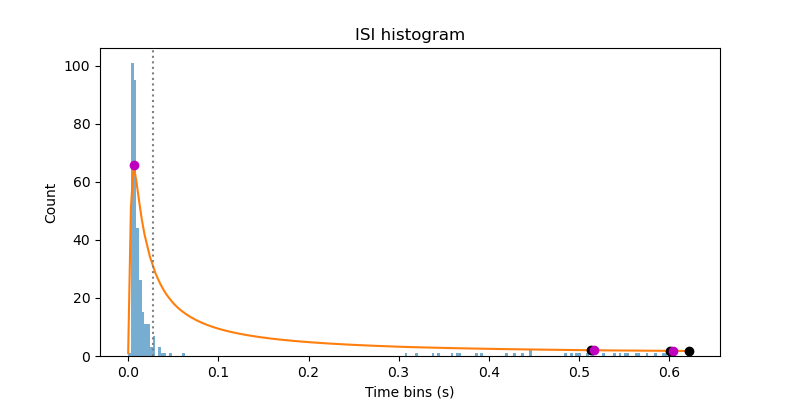

,mean_isi,median_isi,kurtosis,skewness,cma_threshold,cma_valley_time,cma_peak_time
0,0.05835,0.0082,74.182025,8.435033,0.027,0.597,0.006


In [11]:
# Assign ISI data to this variable
hist_data = spikes_table['isi_s']
 
# Empty DataFrame for histogram stats
hist_stats = pd.DataFrame()
 
# Bin size
bin_size = 3  # in miliseconds
 
# Histogram
isi_range = np.ptp(hist_data)
bins = int((isi_range * 1000 / bin_size) + 0.5)  # Round to the nearest integer
hist = np.histogram(hist_data, bins=bins)
hist_counts = hist[0]
hist_bins = hist[1]
 
# Cumulative moving average
cum = np.cumsum(hist_counts)  # Cumulative sum
cma = cum / np.arange(1, len(cum) + 1)
 
# Calculate peaks and valleys of the cma
cma_peaks_indexes = scipy.signal.argrelextrema(cma, np.greater)
cma_valleys_indexes = scipy.signal.argrelextrema(cma, np.less)
 
# Select the peak you're interested in
peak_index = cma_peaks_indexes[0][0]  # Change second number to select the peak
alpha = cma[peak_index] * 0.5  # Half-peak, adapt the value to your threshold criterion
 
# Calculate cma_threshold_index relative to the selected cma_peak
cma_threshold = (np.argmin(cma[peak_index:] >= alpha) + peak_index) * bin_size/1000
 
# Dataframe with histogram statistics
length = len(hist_stats)
hist_stats.loc[length, 'mean_isi'] = np.mean(hist_data)
hist_stats.loc[length, 'median_isi'] = np.median(hist_data)
hist_stats.loc[length, 'kurtosis'] = kurtosis(hist_counts)
hist_stats.loc[length, 'skewness'] = skew(hist_counts, bias=True)
hist_stats.loc[length, 'cma_threshold'] = cma_threshold
hist_stats.loc[length, 'cma_valley_time'] = cma_valleys_indexes[0][1] * bin_size/1000  # Change peak index as needed
hist_stats.loc[length, 'cma_peak_time'] = cma_peaks_indexes[0][0] * bin_size/1000  # Change peak index as needed
 
# Plot ISI histogram
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("ISI histogram") 
ax.hist(hist_data, bins=bins, alpha=0.6)
 
# Plot CMA
cma_x = np.linspace(np.min(hist_bins), np.max(hist_bins), bins)
ax.plot(cma_x, cma)
 
# Plot CMA threshold line
ax.axvline(cma_threshold, linestyle="dotted", color="gray")
 
# Plot CMA valleys
ax.plot(cma_x[cma_valleys_indexes], cma[cma_valleys_indexes], 'ko')
ax.plot(cma_x[cma_peaks_indexes], cma[cma_peaks_indexes], 'mo')
 
# ax.set_xscale('log')  # Logarithmic scale may be easier to set the threshold
ax.set_xlabel("Time bins (s)")
ax.set_ylabel("Count")
 
# Show graph and table
plt.show()
hist_stats

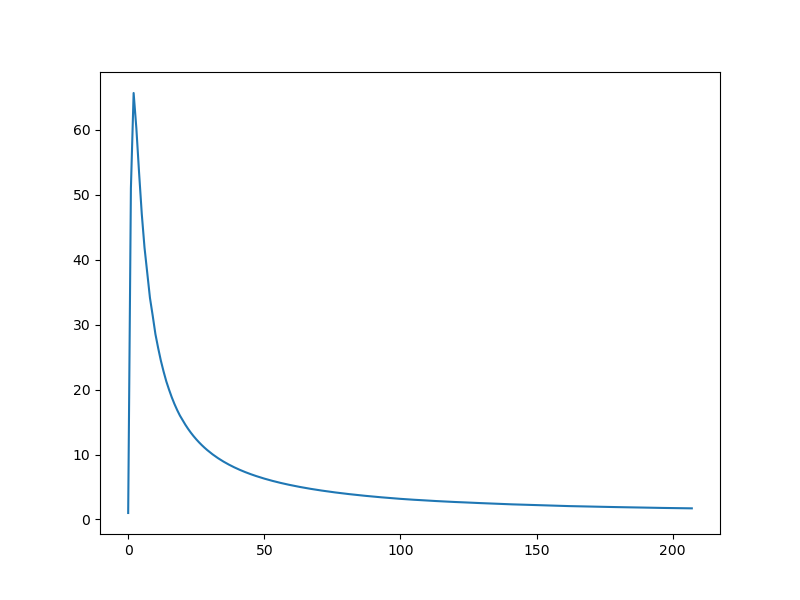

In [12]:
# Assign ISI data to this variable
hist_data = spikes_table['isi_s']
 
# Empty DataFrame for histogram stats
hist_stats = pd.DataFrame()
 
# Bin size
bin_size = 3  # in miliseconds
 
# Histogram
isi_range = np.ptp(hist_data)
bins = int((isi_range * 1000 / bin_size) + 0.5)  # Round to the nearest integer
hist = np.histogram(hist_data, bins=bins)
hist_counts = hist[0]
hist_bins = hist[1]
 
# Cumulative moving average
mycum = np.cumsum(hist_counts)  # Cumulative sum
mycma = mycum / np.arange(1, len(mycum) + 1)

plt.figure(figsize=(8, 6))
plt.plot(mycma)
plt.show()

In [13]:
abf = pyabf.ABF(file_path_89)
abf.setSweep(15)

# Extract sweep data
time = abf.sweepX  # Time axis for the sweep
voltage = abf.sweepY  # Voltage data for the sweep

# Detect spikes using a threshold or peak detection
threshold = -35  # Set your voltage threshold for spike detection (e.g., -20 mV)
spike_indices, _ = find_peaks(voltage, height=threshold)

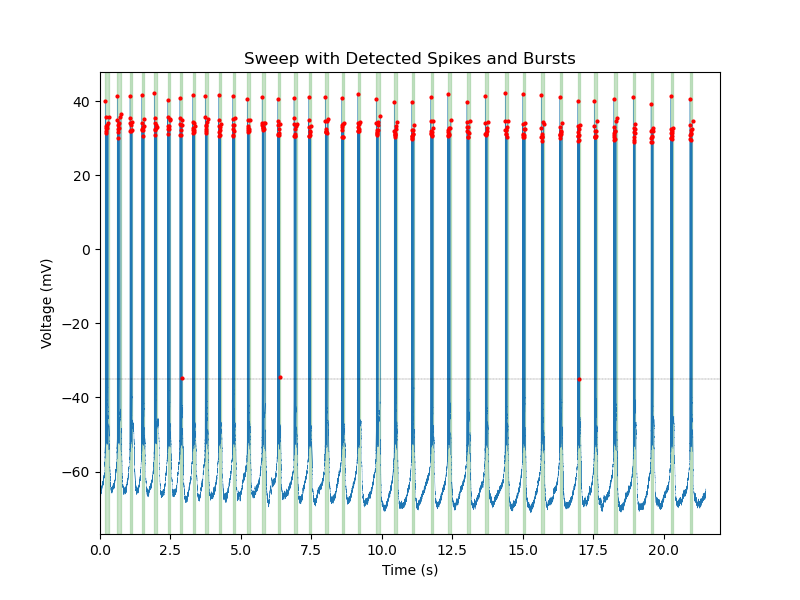

In [14]:
# Detect spikes
threshold = -35  # Set your voltage threshold for spike detection (e.g., -20 mV)
spike_indices, _ = find_peaks(voltage, height=threshold)
spike_times = time[spike_indices]  # Convert spike indices to times

# Detect bursts based on ISI
isi = np.diff(spike_times)  # Inter-spike intervals
burst_threshold = 0.3  # Define an ISI threshold for bursts (e.g., 20 ms)

# Identify bursts
bursts = []
current_burst = [spike_times[0]]  # Initialize the first burst with the first spike
for i in range(1, len(isi)):
    if isi[i - 1] < burst_threshold:  # Continue the burst
        current_burst.append(spike_times[i])
    else:  # End the current burst and start a new one
        if len(current_burst) > 1:  # Only consider bursts with more than 1 spike
            bursts.append((current_burst[0], current_burst[-1]))
        current_burst = [spike_times[i]]
# Add the last burst if valid
if len(current_burst) > 1:
    bursts.append((current_burst[0], current_burst[-1]))

# Plot the sweep, spikes, and bursts
plt.figure(figsize=(8, 6))
plt.plot(time, voltage, label='Sweep Data',lw=0.2)
plt.plot(time[spike_indices], voltage[spike_indices], 'r.', label='Spikes', markersize=4)

# Highlight bursts with shaded regions
for burst_start, burst_end in bursts:
    plt.axvspan(burst_start, burst_end, color='green', alpha=0.2, label='Burst')

plt.axhline(threshold, color='k', linestyle='--', label='Threshold',lw=0.2)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Sweep with Detected Spikes and Bursts")
plt.xlim((0,22))
#plt.legend()
plt.show()

# Print detected bursts
#for i, (burst_start, burst_end) in enumerate(bursts):
#    print(f"Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

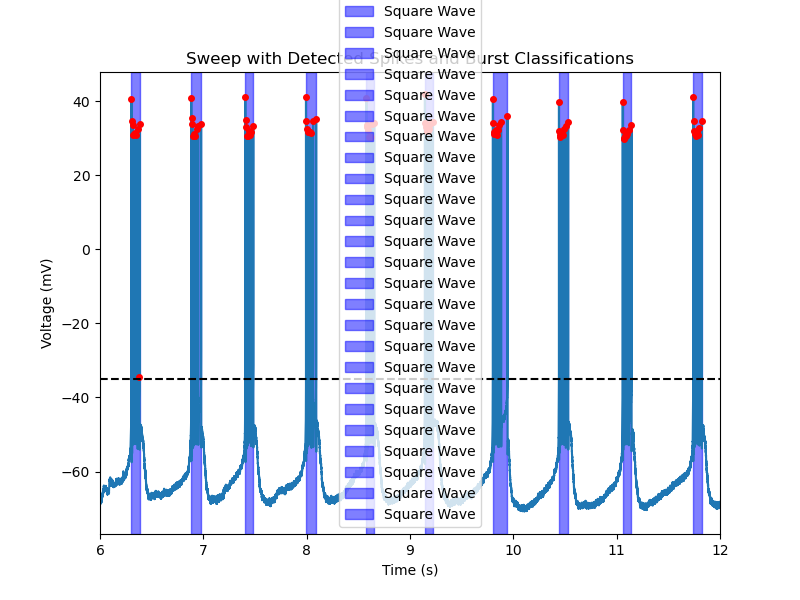

Square Wave Bursts:
  Burst 1: Start = 0.193 s, End = 0.307 s
  Burst 2: Start = 0.615 s, End = 0.744 s
  Burst 3: Start = 1.064 s, End = 1.145 s
  Burst 4: Start = 1.484 s, End = 1.574 s
  Burst 5: Start = 1.933 s, End = 2.010 s
  Burst 6: Start = 2.403 s, End = 2.491 s
  Burst 7: Start = 2.836 s, End = 2.925 s
  Burst 8: Start = 3.293 s, End = 3.367 s
  Burst 9: Start = 3.733 s, End = 3.824 s
  Burst 10: Start = 4.211 s, End = 4.286 s
  Burst 11: Start = 4.705 s, End = 4.783 s
  Burst 12: Start = 5.229 s, End = 5.306 s
  Burst 13: Start = 5.751 s, End = 5.869 s
  Burst 14: Start = 6.304 s, End = 6.382 s
  Burst 15: Start = 6.883 s, End = 6.979 s
  Burst 16: Start = 7.406 s, End = 7.483 s
  Burst 17: Start = 7.993 s, End = 8.092 s
  Burst 18: Start = 8.578 s, End = 8.654 s
  Burst 19: Start = 9.144 s, End = 9.219 s
  Burst 20: Start = 9.802 s, End = 9.944 s
  Burst 21: Start = 10.442 s, End = 10.530 s
  Burst 22: Start = 11.059 s, End = 11.144 s
  Burst 23: Start = 11.740 s, End = 11.

In [15]:
# Initialize lists for categorized bursts
square_wave_bursts = []
parabolic_bursts = []
other_bursts = []

for i, (burst_start, burst_end) in enumerate(bursts):
    # Calculate the minimum voltage during the burst
    burst_mask = (time >= burst_start) & (time <= burst_end)
    burst_min_voltage = np.min(voltage[burst_mask])

    # Calculate mean voltage during the preceding inter-burst interval
    if i > 0:  # Check if there's a previous burst
        prev_end = bursts[i - 1][1]
        inter_burst_prev_mask = (time > prev_end) & (time < burst_start)
        prev_mean_voltage = np.mean(voltage[inter_burst_prev_mask])
    else:
        prev_mean_voltage = float('nan')  # No previous interval, ignore in comparison
    #curr_start = bursts[i][0]
    #bef_curr_burst_mask = (time > curr_start-1) & (time < curr_start)
    #prev_mean_voltage = np.mean(voltage[bef_curr_burst_mask])
        
    # Calculate mean voltage during the succeeding inter-burst interval
    if i < len(bursts) - 1:  # Check if there's a next burst
        next_start = bursts[i + 1][0]
        inter_burst_next_mask = (time > burst_end) & (time < next_start)
        next_mean_voltage = np.mean(voltage[inter_burst_next_mask])
    else:
        next_mean_voltage = float('nan')  # No next interval, ignore in comparison
    #curr_end = bursts[i][1]
    #aft_curr_burst_mask = (time > curr_end) & (time < curr_end+1)
    #next_mean_voltage = np.mean(voltage[aft_curr_burst_mask])
        
    # Calculate overall inter-burst mean voltage
    inter_burst_mean = np.nanmean([prev_mean_voltage, next_mean_voltage])

    # Test conditions to classify the burst
    if burst_min_voltage > inter_burst_mean:
        square_wave_bursts.append((burst_start, burst_end))
    elif burst_min_voltage < inter_burst_mean:
        parabolic_bursts.append((burst_start, burst_end))
    else:
        other_bursts.append((burst_start, burst_end))

# Plot the sweep with classified bursts highlighted
plt.figure(figsize=(8, 6))
plt.plot(time, voltage, label='Sweep Data')
plt.plot(time[spike_indices], voltage[spike_indices], 'r.', label='Spikes', markersize=8)

# Highlight bursts with a single legend entry per category
square_wave_patch = None
parabolic_patch = None
other_patch = None

for burst_start, burst_end in square_wave_bursts:
    square_wave_patch = plt.axvspan(burst_start, burst_end, color='blue', alpha=0.5, label='Square Wave')

for burst_start, burst_end in parabolic_bursts:
    parabolic_patch = plt.axvspan(burst_start, burst_end, color='green', alpha=0.5, label='Parabolic')

for burst_start, burst_end in other_bursts:
    other_patch = plt.axvspan(burst_start, burst_end, color='orange', alpha=0.5, label='Other')

# Filter out None handles
#handles = [patch for patch in [square_wave_patch, parabolic_patch, other_patch] if patch is not None]
#labels = ['Square Wave', 'Parabolic', 'Other'][:len(handles)]

# Add a single legend entry for each classification
#plt.legend(handles, labels)

plt.axhline(threshold, color='k', linestyle='--', label='Threshold')
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Sweep with Detected Spikes and Burst Classifications")
plt.xlim((6,12))
plt.legend()
plt.show()

# Print results
print("Square Wave Bursts:")
for i, (burst_start, burst_end) in enumerate(square_wave_bursts):
    print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

print("\nParabolic Bursts:")
for i, (burst_start, burst_end) in enumerate(parabolic_bursts):
    print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

print("\nOther Bursts:")
for i, (burst_start, burst_end) in enumerate(other_bursts):
    print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")
